In [54]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from gpytorch.kernels import Kernel
import pickle
from sklearn.preprocessing import StandardScaler
from gpytorch.means import Mean
from sklearn.metrics import mean_squared_error
from gpytorch.kernels import Kernel, RBFKernel,ScaleKernel
from gpytorch.constraints import Interval
from gpytorch.settings import cholesky_jitter
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
import torch.nn as nn
import logging
from itertools import product
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset,TensorDataset
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global variables and configuration

In [55]:
# 创建一个logger
logger = logging.getLogger('my_logger')
logger.setLevel(logging.DEBUG)

# 创建文件处理器，写入日志文件
fh = logging.FileHandler('app.log')
fh.setLevel(logging.DEBUG)

# 创建控制台处理器，输出到控制台
ch = logging.StreamHandler()

# 设置日志格式
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)

# 将处理器添加到logger中
# 创建控制台处理器，输出到控制台
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)

if not any(isinstance(handler, logging.StreamHandler) for handler in logger.handlers):
    logger.addHandler(fh)
    logger.addHandler(ch)
    print("StreamHandler added")
else:
    print("StreamHandler already exists")

if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available!")
USE_TOY_DATASET=False

StreamHandler already exists
GPU is not available!


# Helper functions

In [56]:
def load_dataset(X_path,y_path,X_domain_path=None,do_standardisation=False,test_size=0.1,random_state=42):
    X_df=None
    X_domain_info=None
    y_df=None
    with open(X_path, 'rb') as f:
        X_df = pickle.load(f)
    with open(y_path, 'rb') as f:
        y_df = pickle.load(f)
    print(X_df.shape)
    print(y_df.shape)
    if X_domain_path!=None:
        with open(X_domain_path, 'rb') as f:
            X_domain_info = pickle.load(f)
        print(X_domain_info.shape)
        X_train, X_test, y_train, y_test,X_D_train,X_D_test = train_test_split(X_df, y_df,X_domain_info, test_size=test_size, random_state=random_state)
    else:
        X_train, X_test, y_train, y_test= train_test_split(X_df, y_df, test_size=test_size, random_state=random_state)
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)

    if X_domain_path!=None:
        X_D_train = np.array(X_D_train, dtype=np.float32)
        X_D_test = np.array(X_D_test, dtype=np.float32)

    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    if do_standardisation:
        print("Performing standardisation")
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train)
    if X_domain_path!=None:
        X_D_train_tensor = torch.tensor(X_D_train)
        X_D_test_tensor = torch.tensor(X_D_test)

    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test)

    if X_domain_path!=None: 
        return (X_train_tensor,X_D_train_tensor,y_train_tensor),(X_test_tensor,X_D_test_tensor,y_test_tensor)
    else:
        return (X_train_tensor,y_train_tensor),(X_test_tensor,y_test_tensor)

def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
        L<1 inverted sigmoid, l=100 - lower upper and lower boundso sigmpoid on y axis (y= [0.1, 0.11])
        bounds [0.8, 10]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, 0.8, -100, 0), (1, 10, 1, 0.9))
    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

def overwrite_to_test():
    VAR=0.09
    AMP=1.0
    train_size=100

    X_sin=torch.linspace(0, 1, train_size)
    X_cos=torch.linspace(0, 1, train_size)
    X_sig=torch.linspace(0, 1, train_size)
    y_sin = AMP*torch.sin(X_sin * (2 * math.pi)) + torch.randn(X_sin.size()) * math.sqrt(VAR)
    y_cos = AMP*torch.cos(X_cos * (2 * math.pi)) + torch.randn(X_cos.size()) * math.sqrt(VAR)
    y_sig = AMP*(torch.sigmoid(15*(X_sig-0.5))-0.5)*2+torch.randn(X_cos.size()) * math.sqrt(VAR)
    # Training data is 100 points in [0,1] inclusive regularly spaced
    X_train_tensor = torch.linspace(0, 1, train_size)
    # True function is sin(2*pi*x) with Gaussian noise

    num_conc=1
    num_feat=1
    nums_domain=torch.Tensor([3])
    num_data=train_size

    X_sin = X_sin.unsqueeze(1)
    X_cos = X_cos.unsqueeze(1)
    X_sig = X_sig.unsqueeze(1)
    y_sin = y_sin.unsqueeze(1)
    y_cos = y_cos.unsqueeze(1)
    y_sig = y_sig.unsqueeze(1)

    X_sin_domain=torch.zeros(train_size,1)
    X_cos_domain=torch.ones(train_size,1)
    X_sig_domain=torch.ones(train_size,1)*2
    X_sin_cat = torch.cat((X_sin_domain, X_sin), dim=1)
    X_cos_cat = torch.cat((X_cos_domain, X_cos), dim=1)
    X_sig_cat = torch.cat((X_sig_domain, X_sig), dim=1)
    X_train_tensor = torch.cat((X_sin_cat, X_cos_cat,X_sig_cat), dim=0)
    y_train_tensor = torch.cat((y_sin, y_cos,y_sig), dim=0)

    f, ax = plt.subplots(1, 3, figsize=(12, 3))
    for i in range(3):
        ax[i].plot(X_train_tensor[i*train_size:(i+1)*train_size,1:].squeeze().numpy(),y_train_tensor[i*train_size:(i+1)*train_size], 'k*')
        axis=X_train_tensor[i*train_size:(i+1)*train_size,1:].flatten().numpy()
        ax[i].set_ylim([-3, 3])
        ax[i].legend(['Observed Data', 'Mean', 'Confidence'])

    # indices = torch.randperm(X_train_tensor.size(0))
    # X_train_tensor = X_train_tensor[indices]
    # y_train_tensor = y_train_tensor[indices]

    test_size=50
    X_sin=torch.linspace(0, 1, test_size)
    X_cos=torch.linspace(0, 1, test_size)
    X_sig=torch.linspace(0, 1, test_size)

    X_sin_domain=torch.zeros(test_size,1)
    X_cos_domain=torch.ones(test_size,1)
    X_sig_domain=torch.ones(test_size,1)*2

    X_sin = X_sin.unsqueeze(1)
    X_cos = X_cos.unsqueeze(1)
    X_sig = X_sig.unsqueeze(1)

    y_sin =AMP* torch.sin(X_sin * (2 * math.pi)) + torch.randn(X_sin.size()) * math.sqrt(VAR)
    y_cos =AMP* torch.cos(X_cos * (2 * math.pi)) + torch.randn(X_cos.size()) * math.sqrt(VAR)
    y_sig =AMP* (torch.sigmoid(15*(X_sig-0.5))-0.5)*2+torch.randn(X_cos.size()) * math.sqrt(VAR)

    X_sin_cat = torch.cat((X_sin_domain, X_sin), dim=1)
    X_cos_cat = torch.cat((X_cos_domain, X_cos), dim=1)
    X_sig_cat = torch.cat((X_sig_domain, X_sig), dim=1)

    # X_test_tensor =X_sin_cat
    # y_test_tensor =y_sin
    
    X_test_tensor = torch.cat((X_sin_cat, X_cos_cat,X_sig_cat), dim=0)
    y_test_tensor = torch.cat((y_sin, y_cos,y_sig), dim=0)

    # X_test_tensor = torch.cat((X_sin_cat, X_cos_cat), dim=0)
    # y_test_tensor = torch.cat((y_sin, y_cos), dim=0)  

def dataloader2tensor(data_loader):
    all_inputs = []
    all_labels = []

    # 遍历 DataLoader 并将所有批次数据合并成一个大张量
    for inputs, labels in data_loader:
        all_inputs.append(inputs)
        all_labels.append(labels)

    # 使用 torch.cat 将所有小批量张量合并成一个大张量
    X_tensor = torch.cat(all_inputs, dim=0)
    y_tensor = torch.cat(all_labels, dim=0)

    # 现在，X_train_tensor 和 y_train_tensor 是重新合并后的大张量
    print(f"X_train_tensor shape: {X_tensor.shape}")
    print(f"y_train_tensor shape: {y_tensor.shape}")
    return X_tensor,y_tensor



In [57]:
class config():
    NUMS_DOMAIN=None
    NUMS_DOMAIN_FEATURE=None
    NUMS_DOMAIN_AS_INT=None
    NUM_CONC=None
    STEP_SIZE=None
    lr=None
    gamma=None
    def __init__(self, NUMS_DOMAIN=None,
                 NUMS_DOMAIN_FEATURE=None,
                 NUMS_DOMAIN_AS_INT=None,
                 NUM_CONC=None,
                 STEP_SIZE=None,
                 lr=None,
                 gamma=None,
                 NUM_FEAT=None,):
        self.NUMS_DOMAIN=NUMS_DOMAIN
        self.NUMS_DOMAIN_FEATURE=NUMS_DOMAIN_FEATURE
        self.NUMS_DOMAIN_AS_INT=NUMS_DOMAIN_AS_INT
        self.NUM_CONC=NUM_CONC
        self.STEP_SIZE=STEP_SIZE
        self.lr=lr
        self.gamma=gamma
        self.NUM_FEAT=NUM_FEAT


## run_test

In [58]:
def run_test(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,model,kernel,config):
    logger.info(f'training starts for model {str(model)} with kernel {str(kernel)}; lr: {config.lr}; step_size:{config.STEP_SIZE}; gamma:{config.gamma}')
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=config.NUM_CONC)

    m = model(X_train_tensor, y_train_tensor, likelihood,kernel,config)

    training_iterations = 500

    # Find optimal model hyperparameters
    m.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(m.parameters(), lr=config.lr)
    STEP_SIZE=config.STEP_SIZE
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=config.gamma)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, m)
    last_loss=1
    avg_loss=0
    this_loss=0
    for i in range(training_iterations):
        # try:
            optimizer.zero_grad()
            output = m(X_train_tensor)
            loss = -mll(output, y_train_tensor)
            loss.backward()
                
            this_loss=loss.item()
            avg_loss+=this_loss
            optimizer.step()  # 更新参数
            scheduler.step()  # 更新学习率
            
            if i%STEP_SIZE==STEP_SIZE-1:
                logger.debug('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
                avg_loss=avg_loss/STEP_SIZE
                if abs((this_loss-avg_loss)/avg_loss)<0.01 or ((this_loss-avg_loss)/avg_loss>0.30 and i>250):
                    logger.info(f'Early cut off at epoch {i} with loss of {this_loss }')
                    break
                        
                avg_loss=0
                    
        # except Exception as e:
        #     logger.error(f"发生了一个异常: {e}")
        #     continue
        
    m.eval()
    likelihood.eval()
    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        distribution = likelihood(m(X_test_tensor))
        mean = distribution.mean
        lower, upper = distribution.confidence_region()
    nll = -torch.distributions.Normal(mean, distribution.variance.sqrt()).log_prob(y_test_tensor).mean().item()

    rmse=torch.sqrt(torch.tensor(mean_squared_error(y_test_tensor.numpy(), mean.numpy()))).item() 
    nmse = rmse / torch.var(y_test_tensor).item()

    logger.info(f'NLL: {nll:.4f}; RMSE: {rmse:.4f}; NMSE: {nmse:.4f}')
    return m,nll



# Kernels

## Kernel Exponential Squared

In [59]:
class Kernel_Exponential_Squared(Kernel):
    def __init__(self,config, **kwargs):
        super().__init__(**kwargs)
        self.height_scales=torch.nn.Parameter(torch.ones((config.NUMS_DOMAIN)))
        self.length_scales=torch.nn.Parameter(torch.ones((config.NUMS_DOMAIN))) 
        self.register_parameter(name='height_scales', parameter=self.height_scales)
        self.register_parameter(name='length_scales', parameter=self.length_scales)
        self.config=config
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # x1_domain   =   x1[:, :num_domain_feat]
        # x1_genetics =   x1[:, num_domain_feat:]
        # x2_domain   =   x2[:, :num_domain_feat]
        # x2_genetics =   x2[:, num_domain_feat:]

        x1_domain   =   x1[:, :self.config.NUMS_DOMAIN_FEATURE]
        x1_genetics =   x1
        x2_domain   =   x2[:, :self.config.NUMS_DOMAIN_FEATURE]
        x2_genetics =   x2

        dist_mat=self.covar_dist(x1_genetics, x2_genetics, square_dist=True, diag=diag, **params)
        height_scales_parsed_1 = self.height_scales[x1_domain.long()].flatten()
        height_scales_parsed_2 = self.height_scales[x2_domain.long()].flatten()
        length_scales_parsed_1 = self.length_scales[x1_domain.long()].flatten()
        length_scales_parsed_2 = self.length_scales[x2_domain.long()].flatten()

        part_L1L2T=torch.sqrt(torch.outer(length_scales_parsed_1*length_scales_parsed_1,length_scales_parsed_2.T*length_scales_parsed_2.T))
        part_L1L1T=length_scales_parsed_1*length_scales_parsed_1
        part_L2L2T=length_scales_parsed_2*length_scales_parsed_2
        part_L1sqrL2sqr=torch.outer(part_L1L1T,torch.ones_like(part_L2L2T).T)+torch.outer(torch.ones_like(part_L1L1T),part_L2L2T)

        part_1=torch.outer(height_scales_parsed_1,height_scales_parsed_2.T)
        part_2=torch.sqrt(2*part_L1L2T/part_L1sqrL2sqr)
        part_3=torch.exp(-dist_mat/part_L1sqrL2sqr)

        result=part_1*part_2*part_3
        if diag:
            return result.diag()
        return result

## K_MS

In [60]:
  
class K_MS(Kernel):
    def __init__(self,config, **kwargs):
        super().__init__(**kwargs)
        self.domain_coefficient=torch.nn.Parameter(torch.rand((config.NUMS_DOMAIN))*2-1)
        self.K_ES=Kernel_Exponential_Squared(config)
        self.register_parameter(name='domain_coefficient', parameter=self.domain_coefficient)
        self.config=config
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        x1_domain   =   x1[:, :self.config.NUMS_DOMAIN_FEATURE]
        x2_domain   =   x2[:, :self.config.NUMS_DOMAIN_FEATURE]

        domain_coefficient_parsed_1=self.domain_coefficient[x1_domain.long()].flatten()
        domain_coefficient_parsed_2=self.domain_coefficient[x2_domain.long()].flatten()
        domain_scaler=torch.outer(torch.tanh(domain_coefficient_parsed_1),torch.tanh(domain_coefficient_parsed_2.T))

        domain_mat=torch.outer(x1_domain.flatten()+1,1/(x2_domain.flatten().T+1))
        mask = (domain_mat == 1.0)

        # 等于1的位置置0
        domain_mat[mask] = 0.0

        # 不等于1的位置置1
        domain_mat[~mask] = 1.0
        # print(domain_scaler)

        
        base_cov=self.K_ES(x1,x2,diag=diag, last_dim_is_batch=last_dim_is_batch, **params)

        final_scaler=(domain_scaler-1.0)*domain_mat+1.0
        return base_cov*final_scaler


## K_Alpha_Beta

In [61]:
class K_Alpha_Beta(Kernel):
    def __init__(self,config, **kwargs):
        super().__init__(**kwargs)
        self.kernels=[]
        for _ in range(config.NUMS_DOMAIN):
            self.kernels.append(RBFKernel())
        self.config=config
        self.alpha= torch.nn.Parameter(torch.rand(config.NUMS_DOMAIN))
        self.beta=torch.nn.Parameter(torch.rand(config.NUMS_DOMAIN))
        self.register_parameter(name='alpha', parameter=self.alpha)
        self.register_parameter(name='beta', parameter=self.beta)
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):#
        x1_domain   =   x1[:, :self.config.NUMS_DOMAIN_FEATURE]
        x2_domain   =   x2[:, :self.config.NUMS_DOMAIN_FEATURE]
        x1_num_data=x1_domain.shape[0]
        x2_num_data=x2_domain.shape[0]
        cov_mats_alpha=torch.zeros([x1_num_data,x2_num_data])
        cov_mats_beta=torch.zeros([x1_num_data,x2_num_data])

        alpha_reparameterized=torch.sqrt(self.alpha*self.alpha)
        beta_reparameterized=torch.sqrt(self.beta*self.beta)
        for i in range(self.config.NUMS_DOMAIN):
            cov_mats_alpha=cov_mats_alpha.add(self.kernels[i](x1, x2, diag=diag, last_dim_is_batch=last_dim_is_batch, **params)*alpha_reparameterized[i])
            cov_mats_beta=cov_mats_beta.add(self.kernels[i](x1, x2, diag=diag, last_dim_is_batch=last_dim_is_batch, **params)*beta_reparameterized[i])

        domain_mat_alpha=torch.outer(x1_domain.flatten()+1,1/(x2_domain.flatten().T+1))
        domain_mat_beta=torch.outer(x1_domain.flatten()+1,1/(x2_domain.flatten().T+1))
        mask = (domain_mat_alpha == 1.0)
        domain_mat_alpha[mask] = 0.0
        domain_mat_alpha[~mask] = 1.0
        domain_mat_beta[mask] = 1.0
        domain_mat_beta[~mask] = 0.0

        
        result=cov_mats_alpha*domain_mat_alpha+cov_mats_beta*domain_mat_beta
        if diag:
            return result.diag()
        return result

## Transferable quadriple

In [62]:
  
class K_MS_with_Feat_Scaling(Kernel):
    def __init__(self,config, **kwargs):
        super().__init__(**kwargs)
        
        self.domain_coefficient=torch.nn.Parameter(torch.rand(config.NUMS_DOMAIN)*2-1)
        self.K_ES=Kernel_Exponential_Squared(config)
        self.register_parameter(name='domain_coefficient', parameter=self.domain_coefficient)
        
        
        feature_relateness_init=torch.ones(config.NUM_FEAT)
        self.feature_relateness=torch.nn.Parameter(feature_relateness_init)
        self.register_parameter(name='feature_relateness', parameter=self.feature_relateness)
        self.config=config
        
    
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        x1_domain   =   x1[:, :self.config.NUMS_DOMAIN_FEATURE]
        x2_domain   =   x2[:, :self.config.NUMS_DOMAIN_FEATURE]
        x1_genetic   =   x1[:, self.config.NUMS_DOMAIN_FEATURE:]
        x2_genetic   =   x2[:, self.config.NUMS_DOMAIN_FEATURE:]        
        
        feature_scaler_rep=(torch.tanh(self.feature_relateness)+1.0)
        x1_scaled=x1_genetic*torch.outer(torch.ones(x1.shape[0]),feature_scaler_rep)
        x2_scaled=x2_genetic*torch.outer(torch.ones(x2.shape[0]),feature_scaler_rep)
        domain_coefficient_parsed_1=self.domain_coefficient[x1_domain.long()].flatten()
        domain_coefficient_parsed_2=self.domain_coefficient[x2_domain.long()].flatten()
        domain_scaler=torch.outer(torch.tanh(domain_coefficient_parsed_1),torch.tanh(domain_coefficient_parsed_2.T))
        domain_mat=torch.outer(x1_domain.flatten()+1,1/(x2_domain.flatten().T+1))
        mask = (domain_mat == 1.0)

        # 等于1的位置置0
        domain_mat[mask] = 0.0

        # 不等于1的位置置1
        domain_mat[~mask] = 1.0
        # print(domain_scaler)
        x1_cat=torch.cat((x1_domain, x1_scaled), dim=1)
        x2_cat=torch.cat((x2_domain, x2_scaled), dim=1)
        base_cov=self.K_ES(x1_cat,x2_cat,diag=diag, last_dim_is_batch=last_dim_is_batch, **params)

        final_scaler=(domain_scaler-1.0)*domain_mat+1.0
        return base_cov*final_scaler


# Models

## Linear model of corregionalization

In [63]:
class Linear_Model_Of_Corregionalization(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,likelihood,kernel,config):
        super(Linear_Model_Of_Corregionalization, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=config.NUM_CONC
        )
        kernels=[]
        if kernel==RBFKernel:
            for _ in range(config.NUM_CONC):
                kernels.append(kernel())
        else:
            for _ in range(config.NUM_CONC):
                kernels.append(kernel(config))
        self.covar_module =gpytorch.kernels.LCMKernel(
            kernels, num_tasks=config.NUM_CONC, rank=config.NUM_CONC
        )

        logger.debug("Completed")

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

## Multitask GP

In [64]:
class MultitaskGP(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,likelihood,kernel,config):
        super(MultitaskGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=config.NUM_CONC
        )
        kernels=[]
        
        if kernel==RBFKernel:
            kern=kernel()
        else:
            kern=kernel(config)
                
        self.covar_module =gpytorch.kernels.MultitaskKernel(
            kern, num_tasks=config.NUM_CONC, rank=config.NUM_CONC
        )
        #     self.covar_module = gpytorch.kernels.MultitaskKernel(
        #         K_MS(),  # 2 latent GP's

        #     num_tasks=num_conc, rank=num_conc-1
        # )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [65]:
# X_path="data/X_df_toy.pkl"
# y_path="data/y_df_toy.pkl"

# X_path="data/full_shots_Shikonin/X_df.pkl"
# y_path="data/full_shots_Shikonin/y_df.pkl"
# X_domain_path="data/full_shots_Shikonin/X_domain_info.pkl"

Global=config()

# X_path="data/X_df_2_shots.pkl"
# y_path="data/y_df_2_shots.pkl"
# X_domain_path="data/X_domain_info_2_shots.pkl"

# X_path="data/2_shots_4_params_sigmoid/X_df.pkl"
# y_path="data/2_shots_4_params_sigmoid/y_df.pkl"
# X_domain_path="data/2_shots_4_params_sigmoid/X_domain_info.pkl"

X_path="data/8_shots/X_df.pkl"
y_path="data/8_shots/y_df.pkl"
X_domain_path="data/8_shots/X_domain_info.pkl"

# X_path="data/2_shots/X_df.pkl"
# y_path="data/2_shots/y_df.pkl"
# X_domain_path="data/2_shots/X_domain_info.pkl"
(X_train_tensor,X_D_train_tensor,y_train_tensor),(X_test_tensor,X_D_test_tensor,y_test_tensor)=load_dataset(X_path,y_path,X_domain_path=X_domain_path)

print(X_train_tensor.shape)
print(X_D_train_tensor.shape)
print(y_train_tensor.shape)

Global.NUM_CONC=y_train_tensor.shape[1]

Global.NUM_FEAT=X_train_tensor.shape[1]
Global.NUM_DOMAIN_FEAT=X_D_train_tensor.shape[1]
NUMS_DOMAIN, max_indices_row = torch.max(X_D_train_tensor, dim=0)
NUMS_DOMAIN.add_(1)


print(f'NUMS_DOMAIN: {NUMS_DOMAIN.item()}')
Global.NUMS_DOMAIN=NUMS_DOMAIN.long()
X_train_tensor = torch.cat((X_D_train_tensor, X_train_tensor), dim=1)
X_test_tensor = torch.cat((X_D_test_tensor, X_test_tensor), dim=1)
print(X_train_tensor.shape)
print(X_test_tensor.shape)

with open(X_path, 'rb') as f:
    X_df = pickle.load(f)


(153, 1084)
(153, 10)
(153, 1)
torch.Size([137, 1084])
torch.Size([137, 1])
torch.Size([137, 10])
NUMS_DOMAIN: 8.0
torch.Size([137, 1085])
torch.Size([16, 1085])


# Tests

In [66]:
Global.lr=0.1
Global.gamma=0.5
Global.STEP_SIZE=50
Global.NUMS_DOMAIN_FEATURE=1

In [67]:
params= [
    # [MultitaskGP, RBFKernel, 0.18, 55, 0.8],
    # [Linear_Model_Of_Corregionalization, RBFKernel, 0.1, 60, 0.8],
    # [MultitaskGP, K_MS, 0.18, 55, 0.65],
    [Linear_Model_Of_Corregionalization, K_Alpha_Beta,0.69, 33, 0.2],
    # [MultitaskGP, K_MS_with_Feat_Scaling, 0.18, 55,0.65],
]

In [68]:
X = torch.cat((X_train_tensor, X_test_tensor), dim=0)
y = torch.cat((y_train_tensor, y_test_tensor), dim=0)
dataset = TensorDataset(X, y)

# 定义 KFold，n_splits=10 表示 10-fold 交叉验证
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 用于存储每个 fold 的结果
fold_results = {}
m=[]
nlls=[]
for each_param in params:
        Global.lr=each_param[2]
        Global.STEP_SIZE=each_param[3]
        Global.gamma=each_param[4]
        for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
            logger.info('--------------------------------')
            logger.info(f'FOLD {fold+1}')

            
            # 创建训练和验证数据集
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)
            
            # 创建数据加载器
            train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
            X_train_tensor,y_train_tensor=dataloader2tensor(train_loader)
            X_test_tensor,y_test_tensor=dataloader2tensor(val_loader)
            try:
                md,n=run_test(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,model=each_param[0],kernel=each_param[1],config=Global)
                m.append(md)
                nlls.append(n)
            except Exception as e:
                logger.error(f"发生了一个异常: {e}")
                continue


2024-09-06 17:30:36,416 - INFO - --------------------------------
2024-09-06 17:30:36,417 - INFO - FOLD 1
2024-09-06 17:30:36,419 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:30:36,429 - DEBUG - Completed


X_train_tensor shape: torch.Size([137, 1085])
y_train_tensor shape: torch.Size([137, 10])
X_train_tensor shape: torch.Size([16, 1085])
y_train_tensor shape: torch.Size([16, 10])


2024-09-06 17:30:43,535 - DEBUG - Iter 33/500 - Loss: 0.994
2024-09-06 17:30:50,710 - DEBUG - Iter 66/500 - Loss: -0.366
2024-09-06 17:30:57,406 - DEBUG - Iter 99/500 - Loss: -0.950
2024-09-06 17:31:03,999 - DEBUG - Iter 132/500 - Loss: -1.126
2024-09-06 17:31:10,418 - DEBUG - Iter 165/500 - Loss: -1.244
2024-09-06 17:31:16,901 - DEBUG - Iter 198/500 - Loss: -1.267
2024-09-06 17:31:16,901 - INFO - Early cut off at epoch 197 with loss of -1.2670520544052124
2024-09-06 17:31:17,309 - INFO - NLL: -1.0605; RMSE: 0.2341; NMSE: 1.1836
2024-09-06 17:31:17,311 - INFO - --------------------------------
2024-09-06 17:31:17,312 - INFO - FOLD 2
2024-09-06 17:31:17,314 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:31:17,322 - DEBUG - Completed


X_train_tensor shape: torch.Size([137, 1085])
y_train_tensor shape: torch.Size([137, 10])
X_train_tensor shape: torch.Size([16, 1085])
y_train_tensor shape: torch.Size([16, 10])


2024-09-06 17:31:24,059 - DEBUG - Iter 33/500 - Loss: 0.762
2024-09-06 17:31:30,470 - DEBUG - Iter 66/500 - Loss: -0.256
2024-09-06 17:31:36,892 - DEBUG - Iter 99/500 - Loss: -0.817
2024-09-06 17:31:43,333 - DEBUG - Iter 132/500 - Loss: -1.068
2024-09-06 17:31:49,819 - DEBUG - Iter 165/500 - Loss: -1.060
2024-09-06 17:31:56,226 - DEBUG - Iter 198/500 - Loss: -1.057
2024-09-06 17:31:56,227 - INFO - Early cut off at epoch 197 with loss of -1.0574140548706055
2024-09-06 17:31:56,636 - INFO - NLL: -0.6869; RMSE: 0.2151; NMSE: 1.0260
2024-09-06 17:31:56,638 - INFO - --------------------------------
2024-09-06 17:31:56,638 - INFO - FOLD 3
2024-09-06 17:31:56,640 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:31:56,651 - DEBUG - Completed


X_train_tensor shape: torch.Size([137, 1085])
y_train_tensor shape: torch.Size([137, 10])
X_train_tensor shape: torch.Size([16, 1085])
y_train_tensor shape: torch.Size([16, 10])


2024-09-06 17:32:03,175 - DEBUG - Iter 33/500 - Loss: 0.865
2024-09-06 17:32:09,555 - DEBUG - Iter 66/500 - Loss: -0.427
2024-09-06 17:32:15,953 - DEBUG - Iter 99/500 - Loss: -0.909
2024-09-06 17:32:22,497 - DEBUG - Iter 132/500 - Loss: -1.283
2024-09-06 17:32:29,147 - DEBUG - Iter 165/500 - Loss: -1.313
2024-09-06 17:32:35,682 - DEBUG - Iter 198/500 - Loss: -1.266
2024-09-06 17:32:42,132 - DEBUG - Iter 231/500 - Loss: -1.285
2024-09-06 17:32:42,132 - INFO - Early cut off at epoch 230 with loss of -1.2849138975143433
2024-09-06 17:32:42,551 - INFO - NLL: -1.0192; RMSE: 0.2338; NMSE: 1.1233
2024-09-06 17:32:42,554 - INFO - --------------------------------
2024-09-06 17:32:42,554 - INFO - FOLD 4
2024-09-06 17:32:42,557 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:32:42,568 - DEBUG - Completed


X_train_tensor shape: torch.Size([138, 1085])
y_train_tensor shape: torch.Size([138, 10])
X_train_tensor shape: torch.Size([15, 1085])
y_train_tensor shape: torch.Size([15, 10])


2024-09-06 17:32:49,111 - DEBUG - Iter 33/500 - Loss: 0.988
2024-09-06 17:32:55,579 - DEBUG - Iter 66/500 - Loss: -0.291
2024-09-06 17:33:02,004 - DEBUG - Iter 99/500 - Loss: -1.083
2024-09-06 17:33:08,389 - DEBUG - Iter 132/500 - Loss: -1.240
2024-09-06 17:33:14,789 - DEBUG - Iter 165/500 - Loss: -1.294
2024-09-06 17:33:21,251 - DEBUG - Iter 198/500 - Loss: -1.320
2024-09-06 17:33:27,812 - DEBUG - Iter 231/500 - Loss: -1.318
2024-09-06 17:33:34,181 - DEBUG - Iter 264/500 - Loss: -1.295
2024-09-06 17:33:34,181 - INFO - Early cut off at epoch 263 with loss of -1.2946045398712158
2024-09-06 17:33:34,598 - INFO - NLL: -1.0275; RMSE: 0.2289; NMSE: 1.0977
2024-09-06 17:33:34,599 - INFO - --------------------------------
2024-09-06 17:33:34,600 - INFO - FOLD 5
2024-09-06 17:33:34,602 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:33:34,610 - DEBUG - Completed

X_train_tensor shape: torch.Size([138, 1085])
y_train_tensor shape: torch.Size([138, 10])
X_train_tensor shape: torch.Size([15, 1085])
y_train_tensor shape: torch.Size([15, 10])


2024-09-06 17:33:41,300 - DEBUG - Iter 33/500 - Loss: 0.859
2024-09-06 17:33:47,802 - DEBUG - Iter 66/500 - Loss: -0.574
2024-09-06 17:33:54,312 - DEBUG - Iter 99/500 - Loss: -1.142
2024-09-06 17:34:00,834 - DEBUG - Iter 132/500 - Loss: -1.240
2024-09-06 17:34:07,250 - DEBUG - Iter 165/500 - Loss: -1.265
2024-09-06 17:34:07,250 - INFO - Early cut off at epoch 164 with loss of -1.2648550271987915
2024-09-06 17:34:07,659 - INFO - NLL: -1.0786; RMSE: 0.2127; NMSE: 1.0915
2024-09-06 17:34:07,661 - INFO - --------------------------------
2024-09-06 17:34:07,662 - INFO - FOLD 6
2024-09-06 17:34:07,664 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:34:07,672 - DEBUG - Completed


X_train_tensor shape: torch.Size([138, 1085])
y_train_tensor shape: torch.Size([138, 10])
X_train_tensor shape: torch.Size([15, 1085])
y_train_tensor shape: torch.Size([15, 10])


2024-09-06 17:34:14,170 - DEBUG - Iter 33/500 - Loss: 1.086
2024-09-06 17:34:20,687 - DEBUG - Iter 66/500 - Loss: -0.409
2024-09-06 17:34:27,216 - DEBUG - Iter 99/500 - Loss: -1.112
2024-09-06 17:34:33,651 - DEBUG - Iter 132/500 - Loss: -1.273
2024-09-06 17:34:40,077 - DEBUG - Iter 165/500 - Loss: -1.269
2024-09-06 17:34:40,077 - INFO - Early cut off at epoch 164 with loss of -1.2690616846084595
2024-09-06 17:34:40,489 - INFO - NLL: -1.1983; RMSE: 0.1749; NMSE: 0.9057
2024-09-06 17:34:40,491 - INFO - --------------------------------
2024-09-06 17:34:40,492 - INFO - FOLD 7
2024-09-06 17:34:40,494 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:34:40,502 - DEBUG - Completed


X_train_tensor shape: torch.Size([138, 1085])
y_train_tensor shape: torch.Size([138, 10])
X_train_tensor shape: torch.Size([15, 1085])
y_train_tensor shape: torch.Size([15, 10])


2024-09-06 17:34:46,950 - DEBUG - Iter 33/500 - Loss: 0.807
2024-09-06 17:34:53,615 - DEBUG - Iter 66/500 - Loss: -0.537
2024-09-06 17:35:00,131 - DEBUG - Iter 99/500 - Loss: -0.980
2024-09-06 17:35:06,525 - DEBUG - Iter 132/500 - Loss: -1.227
2024-09-06 17:35:12,924 - DEBUG - Iter 165/500 - Loss: -1.307
2024-09-06 17:35:19,410 - DEBUG - Iter 198/500 - Loss: -1.313
2024-09-06 17:35:26,151 - DEBUG - Iter 231/500 - Loss: -1.288
2024-09-06 17:35:26,152 - INFO - Early cut off at epoch 230 with loss of -1.2880754470825195
2024-09-06 17:35:26,563 - INFO - NLL: -1.1406; RMSE: 0.1964; NMSE: 0.9450
2024-09-06 17:35:26,565 - INFO - --------------------------------
2024-09-06 17:35:26,565 - INFO - FOLD 8
2024-09-06 17:35:26,568 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:35:26,578 - DEBUG - Completed


X_train_tensor shape: torch.Size([138, 1085])
y_train_tensor shape: torch.Size([138, 10])
X_train_tensor shape: torch.Size([15, 1085])
y_train_tensor shape: torch.Size([15, 10])


2024-09-06 17:35:33,012 - DEBUG - Iter 33/500 - Loss: 0.953
2024-09-06 17:35:39,506 - DEBUG - Iter 66/500 - Loss: -0.255
2024-09-06 17:35:46,022 - DEBUG - Iter 99/500 - Loss: -1.009
2024-09-06 17:35:52,635 - DEBUG - Iter 132/500 - Loss: -1.232
2024-09-06 17:35:59,024 - DEBUG - Iter 165/500 - Loss: -1.283
2024-09-06 17:36:05,603 - DEBUG - Iter 198/500 - Loss: -1.281
2024-09-06 17:36:05,603 - INFO - Early cut off at epoch 197 with loss of -1.2814234495162964
2024-09-06 17:36:06,035 - INFO - NLL: -1.0681; RMSE: 0.1981; NMSE: 0.9976
2024-09-06 17:36:06,038 - INFO - --------------------------------
2024-09-06 17:36:06,039 - INFO - FOLD 9
2024-09-06 17:36:06,041 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:36:06,054 - DEBUG - Completed


X_train_tensor shape: torch.Size([138, 1085])
y_train_tensor shape: torch.Size([138, 10])
X_train_tensor shape: torch.Size([15, 1085])
y_train_tensor shape: torch.Size([15, 10])


2024-09-06 17:36:12,481 - DEBUG - Iter 33/500 - Loss: 0.824
2024-09-06 17:36:18,991 - DEBUG - Iter 66/500 - Loss: -0.329
2024-09-06 17:36:25,472 - DEBUG - Iter 99/500 - Loss: -1.062
2024-09-06 17:36:31,972 - DEBUG - Iter 132/500 - Loss: -1.230
2024-09-06 17:36:38,415 - DEBUG - Iter 165/500 - Loss: -1.294
2024-09-06 17:36:38,417 - INFO - Early cut off at epoch 164 with loss of -1.2944279909133911
2024-09-06 17:36:38,820 - INFO - NLL: -0.9007; RMSE: 0.2395; NMSE: 1.1651
2024-09-06 17:36:38,822 - INFO - --------------------------------
2024-09-06 17:36:38,823 - INFO - FOLD 10
2024-09-06 17:36:38,825 - INFO - training starts for model <class '__main__.Linear_Model_Of_Corregionalization'> with kernel <class '__main__.K_Alpha_Beta'>; lr: 0.69; step_size:33; gamma:0.2
2024-09-06 17:36:38,835 - DEBUG - Completed


X_train_tensor shape: torch.Size([138, 1085])
y_train_tensor shape: torch.Size([138, 10])
X_train_tensor shape: torch.Size([15, 1085])
y_train_tensor shape: torch.Size([15, 10])


2024-09-06 17:36:45,328 - DEBUG - Iter 33/500 - Loss: 1.011
2024-09-06 17:36:51,880 - DEBUG - Iter 66/500 - Loss: -0.301
2024-09-06 17:36:58,356 - DEBUG - Iter 99/500 - Loss: -1.171
2024-09-06 17:37:04,853 - DEBUG - Iter 132/500 - Loss: -1.290
2024-09-06 17:37:11,477 - DEBUG - Iter 165/500 - Loss: -1.299
2024-09-06 17:37:11,478 - INFO - Early cut off at epoch 164 with loss of -1.2993133068084717
2024-09-06 17:37:11,885 - INFO - NLL: -0.8710; RMSE: 0.2460; NMSE: 1.1389


In [69]:
def print_kernel_params(kernel, depth=0):
    indent = "  " * depth
    # 打印当前核函数的类型和名称
    print(f"{indent}Kernel: {kernel.__class__.__name__}")
    
    # 获取当前核函数的参数
    for name, param in kernel.named_parameters():
        print(f"{indent}  Parameter name: {name}")
        # print(f"{indent}  Parameter value: {param.item()}")

    # 如果是组合核函数，则递归进入子核函数
    if hasattr(kernel, 'kernels'):  # 处理AdditiveKernel, ProductKernel等组合核
        for i, sub_kernel in enumerate(kernel.kernels):
            print(f"{indent}  Sub-kernel {i + 1}:")
            print_kernel_params(sub_kernel, depth + 1)
    elif hasattr(kernel, 'base_kernel'):  # 处理嵌套的核函数（如 ScaleKernel）
        print_kernel_params(kernel.base_kernel, depth + 1)



# 从模型的 covar_module 开始递归搜索核函数参数
print_kernel_params(m[0].covar_module)


Kernel: LCMKernel
  Parameter name: covar_module_list.0.task_covar_module.covar_factor
  Parameter name: covar_module_list.0.task_covar_module.raw_var
  Parameter name: covar_module_list.0.data_covar_module.alpha
  Parameter name: covar_module_list.0.data_covar_module.beta
  Parameter name: covar_module_list.1.task_covar_module.covar_factor
  Parameter name: covar_module_list.1.task_covar_module.raw_var
  Parameter name: covar_module_list.1.data_covar_module.alpha
  Parameter name: covar_module_list.1.data_covar_module.beta
  Parameter name: covar_module_list.2.task_covar_module.covar_factor
  Parameter name: covar_module_list.2.task_covar_module.raw_var
  Parameter name: covar_module_list.2.data_covar_module.alpha
  Parameter name: covar_module_list.2.data_covar_module.beta
  Parameter name: covar_module_list.3.task_covar_module.covar_factor
  Parameter name: covar_module_list.3.task_covar_module.raw_var
  Parameter name: covar_module_list.3.data_covar_module.alpha
  Parameter name: c

In [70]:
# print(m[0].covar_module.covar_module_list[2].data_covar_module.beta)

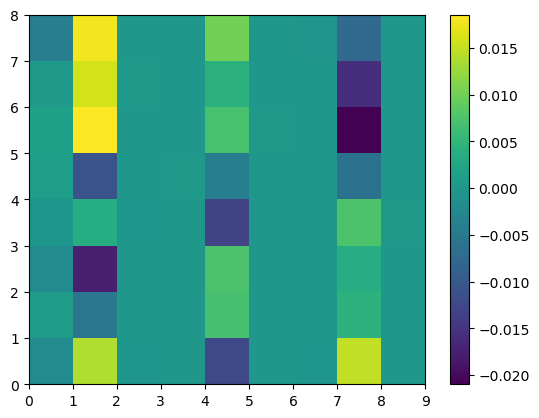

In [76]:
alpha_list = []

# 迭代 covar_module_list 的前 9 个元素
for i in range(9):
    # 提取每个模块的 alpha 值（假设 alpha 是张量）
    alpha = m[0].covar_module.covar_module_list[i].data_covar_module.beta
    
    # 将 alpha 视作列向量（n x 1），需要增加维度
    alpha_column = alpha.view(-1, 1)
    
    # 将列向量添加到列表中
    alpha_list.append(alpha_column)

# 将 9 个列向量水平堆叠成一个矩阵
alpha_matrix = torch.cat(alpha_list, dim=1).detach().numpy()
# 创建热图
plt.pcolormesh(alpha_matrix, cmap='viridis')

# 添加颜色条
plt.colorbar()

# 显示图像
plt.show()
# print(data)

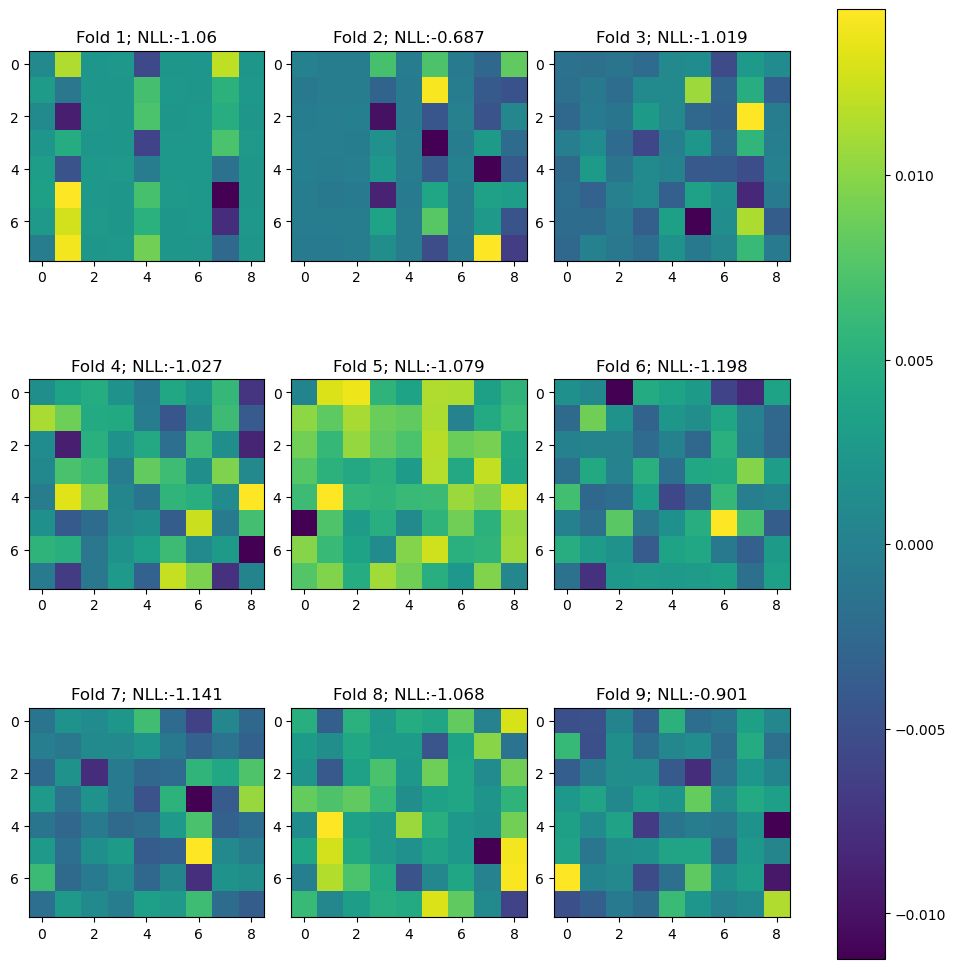

In [75]:
# 创建一个 3x3 的子图网格
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# 遍历每个子图并绘制热图
for i, ax in enumerate(axes.flat):  # axes.flat 将 3x3 网格展平为一维数组
    alpha_list = []
    # 迭代 covar_module_list 的前 9 个元素
    for j in range(9):
        # 提取每个模块的 alpha 值（假设 alpha 是张量）
        alpha = m[i].covar_module.covar_module_list[j].data_covar_module.beta
        
        # 将 alpha 视作列向量（n x 1），需要增加维度
        alpha_column = alpha.view(-1, 1)
        
        # 将列向量添加到列表中
        alpha_list.append(alpha_column)

    # 将 9 个列向量水平堆叠成一个矩阵
    alpha_matrix = torch.cat(alpha_list, dim=1).detach().numpy()
    im = ax.imshow(alpha_matrix)
    ax.set_title(f'Fold {i+1}; NLL:{round(nlls[i],3)}')  # 设置每个热图的标题

# 调整子图间的间距
plt.tight_layout()

# 为最后一个热图添加颜色条
fig.colorbar(im, ax=axes.ravel().tolist())  # 使用最后一个图的颜色条

# 显示图像
plt.show()

In [73]:
h=m[0].covar_module.data_covar_module.domain_coefficient
h=torch.tanh(h)
data=torch.outer(h.T,h).detach().numpy()
np.fill_diagonal(data, 1)
# 创建热图
plt.pcolormesh(data, cmap='viridis')

# 添加颜色条
plt.colorbar()

# 显示图像
plt.show()
print(data)

AttributeError: 'LCMKernel' object has no attribute 'data_covar_module'

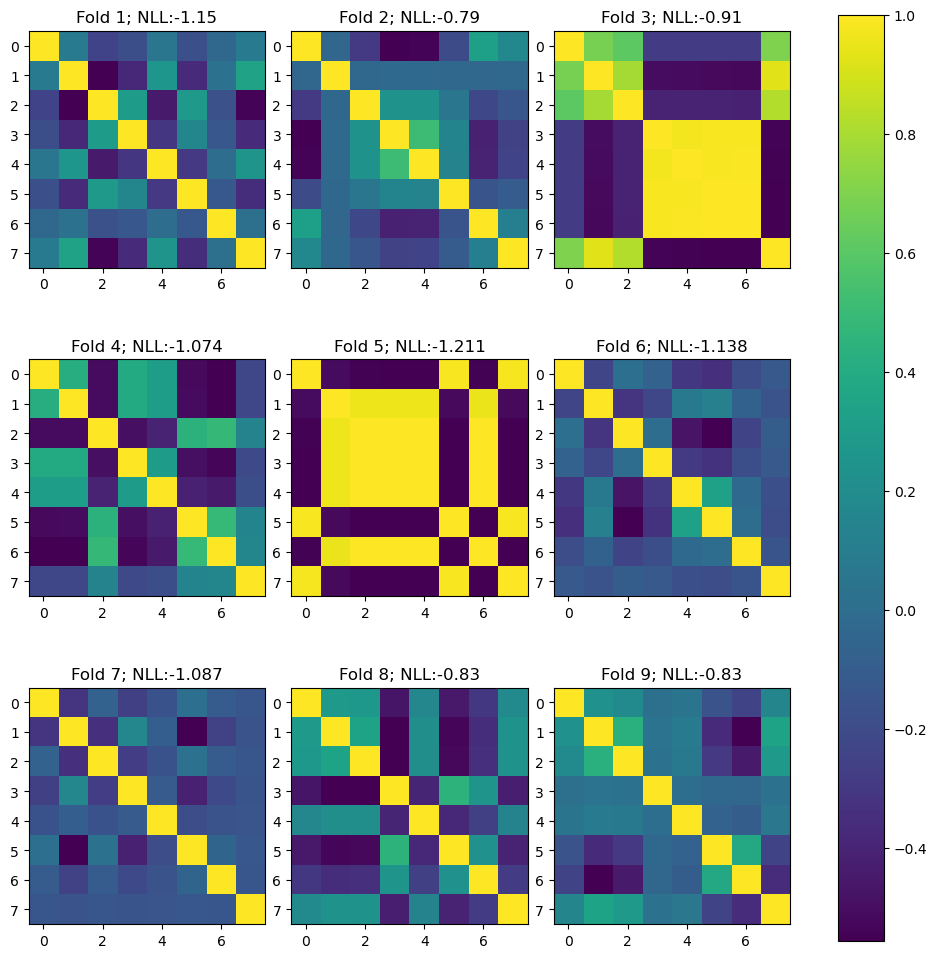

In [52]:

# 创建一个 3x3 的子图网格
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# 遍历每个子图并绘制热图
for i, ax in enumerate(axes.flat):  # axes.flat 将 3x3 网格展平为一维数组
    h=m[i+1].covar_module.data_covar_module.domain_coefficient
    h=torch.tanh(h)
    data=torch.outer(h.T,h).detach().numpy()
    np.fill_diagonal(data, 1)
    im = ax.imshow(data, cmap='viridis')
    ax.set_title(f'Fold {i+1}; NLL:{round(nlls[i+1],3)}')  # 设置每个热图的标题

# 调整子图间的间距
plt.tight_layout()

# 为最后一个热图添加颜色条
fig.colorbar(im, ax=axes.ravel().tolist())  # 使用最后一个图的颜色条

# 显示图像
plt.show()

In [46]:

# param_grid = {
#     'models':[Linear_Model_Of_Corregionalization,MultitaskGP],
#     'kernels': [Quadriple_Kernel_Exponential_Squared],
#     'lrs': torch.log(torch.logspace(0.003,0.3,5)).tolist(),
#     'gammas':torch.linspace(0.2,0.8,5).tolist(),
#     'STEP_SIZEs':torch.linspace(10,100,5).tolist()
# }

# param_grid = {
#     'models':[Linear_Model_Of_Corregionalization],
#     'kernels': [RBFKernel],
#     'lrs': [0.69 ],
#     'gammas':[0.5],
#     'STEP_SIZEs':[33]
# }


# param_combinations = list(product(*param_grid.values()))

In [47]:
# for each_param in param_combinations:
#     Global.lr=each_param[2]
#     Global.gamma=each_param[3]
#     Global.STEP_SIZE=each_param[4]
#     run_test(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,model=each_param[0],kernel=each_param[1],config=Global)

In [48]:
if USE_TOY_DATASET == True:
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Test points are regularly spaced along [0,1]
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(X_test_tensor))

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 3, figsize=(12, 3))

        lower, upper = observed_pred.confidence_region()
        mean=observed_pred.mean.numpy()
        for i in range(3):
            ax[i].plot(X_test_tensor[i*50:(i+1)*50,1:].squeeze().numpy(),mean[i*50:(i+1)*50], 'k*')
            ax[i].fill_between(X_test_tensor[i*50:(i+1)*50,1:].flatten().numpy(), lower[i*50:(i+1)*50].squeeze().numpy(), upper[i*50:(i+1)*50].squeeze().numpy(), alpha=0.5)
            ax[i].set_ylim([-3, 3])
            ax[i].legend(['Observed Data', 'Mean', 'Confidence'])
